In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import time

import matplotlib.pyplot as plt
from scipy import stats as spstats
import torch
import numpy as np

import utils
import fr_models._torch.stats as tstats

Disabled TF32 usage during initialization of fr_models


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

0.003733396530151367
0.000957489013671875


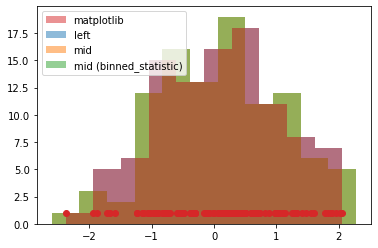

In [8]:
y = torch.normal(mean=0.0,std=1.0,size=(100,),device=device)
N_bins = 10

start = time.time()
grid, binned_y = tstats.bin_values(y, y, N_bins=N_bins, mode='edge', device=device)
print(time.time() - start)
bin_locs = grid.tensor.squeeze()
plt.bar(bin_locs.tolist(), [yi.numel() for yi in binned_y], width=(bin_locs[1] - bin_locs[0]).item(), alpha=0.5, label='left')

grid, binned_y = tstats.bin_values(y, y, N_bins=N_bins+1, mode='mid', device=device)
bin_locs = grid.tensor.squeeze()
plt.bar(bin_locs.tolist(), [yi.numel() for yi in binned_y], width=(bin_locs[1] - bin_locs[0]).item(), alpha=0.5, label='mid')

start = time.time()
grid, stats = tstats.binned_statistic(y, N_bins=N_bins+1, mode='mid', statistics=['count'], device=device)
print(time.time() - start)
bin_locs = grid.tensor.squeeze()
plt.bar(bin_locs.tolist(), stats['count'].tolist(), width=(bin_locs[1] - bin_locs[0]).item(), alpha=0.5, label='mid (binned_statistic)')

plt.hist(y.tolist(), alpha=0.5, bins=N_bins, color='C3', label='matplotlib')

plt.scatter(y.tolist(), np.ones(len(y)))

plt.legend()
plt.show()

0.001773834228515625
0.0007517337799072266


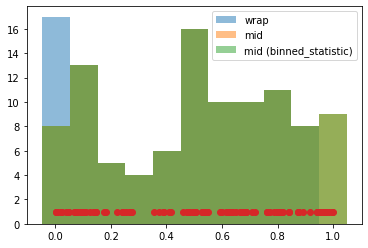

In [10]:
y = torch.rand(100, device=device)
N_bins = 10

start = time.time()
grid, binned_y = tstats.bin_values(y, y, N_bins=N_bins, mode='wrap', ymin=0, ymax=1, device=device)
print(time.time() - start)
bin_locs = grid.tensor.squeeze()
plt.bar(bin_locs.tolist(), [yi.numel() for yi in binned_y], width=(bin_locs[1] - bin_locs[0]).item(), alpha=0.5, label='wrap')

grid, binned_y = tstats.bin_values(y, y, N_bins=N_bins+1, mode='mid', device=device)
bin_locs = grid.tensor.squeeze()
plt.bar(bin_locs.tolist(), [yi.numel() for yi in binned_y], width=(bin_locs[1] - bin_locs[0]).item(), alpha=0.5, label='mid')

start = time.time()
grid, stats = tstats.binned_statistic(y, N_bins=N_bins+1, mode='mid', statistics=['count'], device=device)
print(time.time() - start)
bin_locs = grid.tensor.squeeze()
plt.bar(bin_locs.tolist(), stats['count'].tolist(), width=(bin_locs[1] - bin_locs[0]).item(), alpha=0.5, label='mid (binned_statistic)')

plt.scatter(y.tolist(), np.ones(len(y)))

plt.legend()
plt.show()

0.18344569206237793
0.0015611648559570312
0.013509511947631836


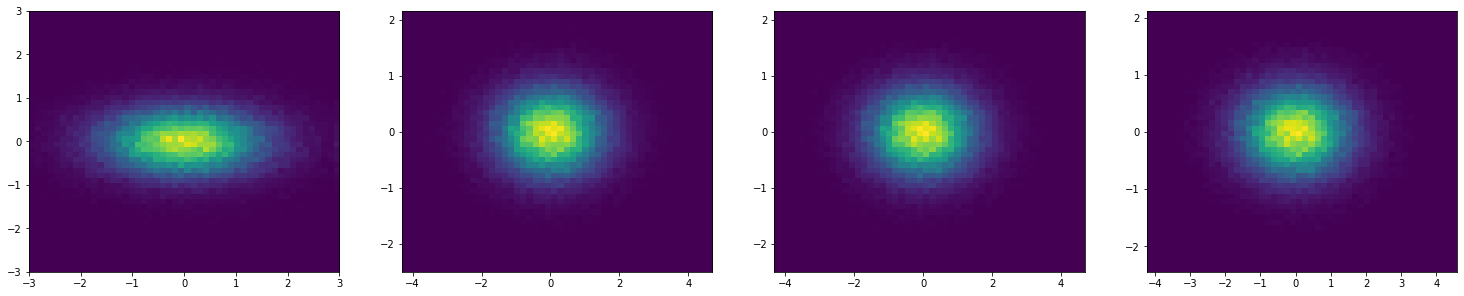

In [12]:
y1 = torch.normal(mean=0.0,std=1.0,size=(1000,100),device=device)
y2 = torch.normal(mean=0.0,std=0.5,size=(1000,100),device=device)
y = torch.stack([y1, y2], dim=-1)

shape = (50,50)

fig, axes = utils.plot.subplots(1,4)

grid, binned_y = tstats.bin_values_n(y, y[...,0], shape=shape, mode='edge', ymin=[-3,-3], ymax=[3,3], device=device)
counts = np.zeros(shape)
for indices in np.ndindex(shape):
    counts[indices] = len(binned_y[indices])
extent = (grid.extents[0][0]-grid.dxs[0]/2,grid.extents[0][1]+grid.dxs[0]/2,grid.extents[1][0]-grid.dxs[1]/2,grid.extents[1][1]+grid.dxs[1]/2)
axes[0].imshow(counts.T, interpolation='none', aspect='auto', origin='lower', extent=extent)

start = time.time()
grid, binned_y = tstats.bin_values_n(y, y[...,0], shape=shape, mode='mid', device=device)
counts = np.zeros(shape)
for indices in np.ndindex(shape):
    counts[indices] = len(binned_y[indices])
print(time.time() - start)
extent = (grid.extents[0][0]-grid.dxs[0]/2,grid.extents[0][1]+grid.dxs[0]/2,grid.extents[1][0]-grid.dxs[1]/2,grid.extents[1][1]+grid.dxs[1]/2)
axes[1].imshow(counts.T, interpolation='none', aspect='auto', origin='lower', extent=extent)

start = time.time()
grid, stats = tstats.binned_statistic_n(y, shape=shape, mode='mid', statistics=['count'], device=device)
stats['count'].T.cpu().numpy()
print(time.time() - start)

start = time.time()
_ = spstats.binned_statistic_dd(y.reshape(-1,2).cpu().numpy(), np.empty(np.prod(y.shape[:-1])), bins=shape, statistic='mean')
print(time.time() - start)

extent = (grid.extents[0][0]-grid.dxs[0]/2,grid.extents[0][1]+grid.dxs[0]/2,grid.extents[1][0]-grid.dxs[1]/2,grid.extents[1][1]+grid.dxs[1]/2)
axes[2].imshow(stats['count'].T.cpu().numpy(), interpolation='none', aspect='auto', origin='lower', extent=extent)

axes[3].hist2d(y[...,0].reshape(-1).tolist(), y[...,1].reshape(-1).tolist(), bins=shape)

plt.show()